"""
Multi-Paradigm ML for Bike Sharing Demand Forecasting
Author: Ali Abdolkhani
Date: 2025-05-20
"""

# Libraries

In [388]:
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (mean_squared_error, accuracy_score,
                             f1_score, roc_auc_score)
from xgboost import XGBRegressor

# 1. Data Loading & Preprocessing

In [390]:
df = pd.read_csv("ml_data/hour.csv")
df["datetime"] = pd.to_datetime(df["dteday"]) + pd.to_timedelta(df["hr"], unit="h")
df.set_index("datetime", inplace=True)
df.drop(columns=["instant", "dteday", "hr"], inplace=True)

np.random.seed(42)

# 2. Outlier Removal (IQR Method)

In [392]:
# Compute IQR bounds on the target 'cnt'
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Filter out extreme hours
original_count = len(df)
df = df[(df['cnt'] >= lower_fence) & (df['cnt'] <= upper_fence)].copy()
print(f"Outlier removal: dropped {original_count - len(df)} of {original_count} records")

# df_full = df.copy()

Outlier removal: dropped 505 of 17379 records


# 3. Feature Engineering

In [394]:
df["cnt_lag1"] = df["cnt"].shift(1)
df["cnt_lag24"] = df["cnt"].shift(24)
df["cnt_lag168"] = df["cnt"].shift(168)
df["hour_sin"] = np.sin(2*np.pi*df.index.hour/24)
df["hour_cos"] = np.cos(2*np.pi*df.index.hour/24)
df["dow_sin"] = np.sin(2*np.pi*df.index.weekday/7)
df["dow_cos"] = np.cos(2*np.pi*df.index.weekday/7)
df["month_sin"] = np.sin(2*np.pi*df.index.month/12)
df["month_cos"] = np.cos(2*np.pi*df.index.month/12)
df["temp_hum"] = df["temp"] * df["hum"]
df["windspeed_temp"] = df["windspeed"] * df["temp"]
df["cnt_roll3"] = df["cnt"].rolling(3).mean()
df["cnt_roll24"] = df["cnt"].rolling(24).mean()
df.dropna(inplace=True)

features = ["temp","hum","windspeed","cnt_lag1","cnt_lag24","hour_sin","hour_cos"]
X = df[features]
y = df["cnt"]

# 4. Bivariate & Multivariate EDA

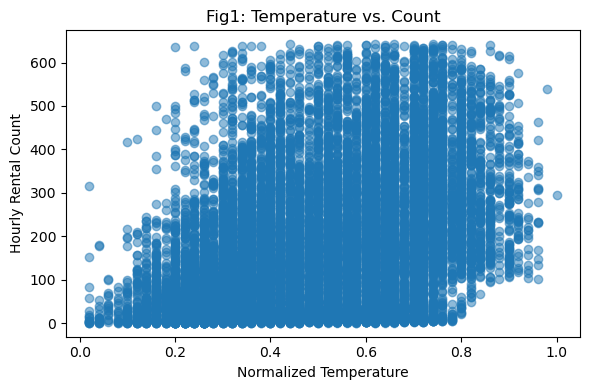

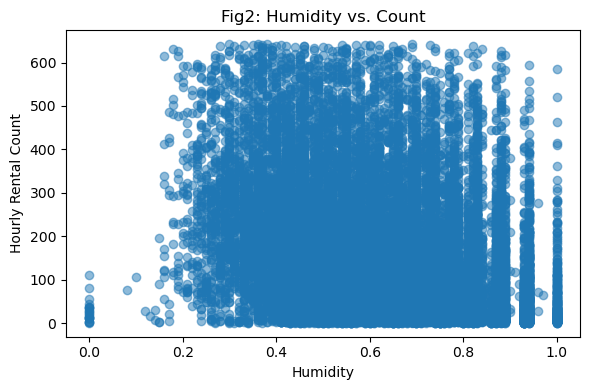

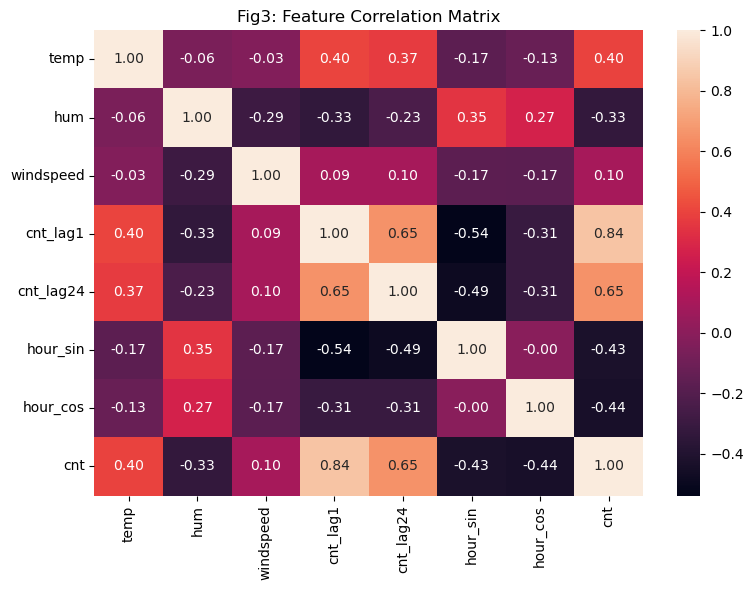

In [396]:
plt.figure(figsize=(6,4))
plt.scatter(df['temp'], df['cnt'], alpha=0.5)
plt.xlabel('Normalized Temperature'); plt.ylabel('Hourly Rental Count')
plt.title('Fig1: Temperature vs. Count'); plt.tight_layout(); plt.savefig('figs/temp_vs_count.png'); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df['hum'], df['cnt'], alpha=0.5)
plt.xlabel('Humidity'); plt.ylabel('Hourly Rental Count')
plt.title('Fig2: Humidity vs. Count'); plt.tight_layout(); plt.savefig('figs/hum_vs_count.png'); plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[features+['cnt']].corr(), annot=True, fmt='.2f')
plt.title('Fig3: Feature Correlation Matrix'); plt.tight_layout(); plt.savefig('figs/corr_matrix.png'); plt.show()

# 5. Supervised Learning

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
tscv = TimeSeriesSplit(n_splits=5)

# Baseline: Linear Regression

In [400]:
lr = LinearRegression().fit(X_train, y_train)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr.predict(X_test))))

Linear Regression RMSE: 89.384601910554


# Random Forest & XGBoost Hyperparameter Tuning

In [402]:
param_grid = {"n_estimators":[50,100,200], "max_depth":[5,10,15], "min_samples_leaf":[1,3,5]}

# Random Forest

In [404]:
gs_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).fit(X_train, y_train)
print("RF best params & RMSE:", gs_rf.best_params_, -gs_rf.best_score_)
best_rf = gs_rf.best_estimator_

RF best params & RMSE: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200} 56.217736447714074


# XGBoost

In [406]:
gs_xgb = GridSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).fit(X_train, y_train)
print("XGB best params & RMSE:", gs_xgb.best_params_, -gs_xgb.best_score_)

XGB best params & RMSE: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50} 55.601686839549004


# Inference Speed Check (on the chosen RF model)

In [408]:
start = time.time()
best_rf.predict(X_test[:1000])
print("Time/1k preds:", time.time() - start)

Time/1k preds: 0.09401059150695801


# 6. Unsupervised

# K-Means

In [410]:
cluster_feats = ["temp","hum","windspeed","cnt"]
Xc = StandardScaler().fit_transform(df[cluster_feats])
km = KMeans(n_clusters=3, random_state=42).fit(Xc)
df['cluster3'] = km.labels_

# Naïve Baseline (Rejested Method)

In [412]:
df['cluster3'] = km.labels_

# Naïve cluster-mean baseline
cluster_means = df.groupby('cluster3')['cnt'].transform('mean')
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
rmse_naive = np.sqrt(mean_squared_error(df_test['cnt'], cluster_means.loc[df_test.index]))
print(f"Naïve cluster-mean RMSE: {rmse_naive:.2f}")

Naïve cluster-mean RMSE: 111.48


# GMM

Optimal GMM components by BIC: 6


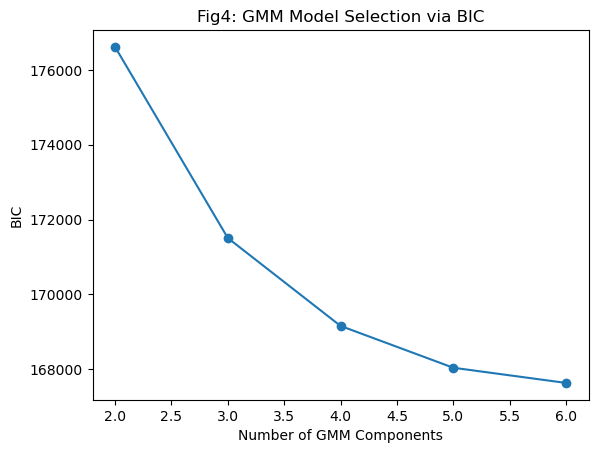

In [414]:
# Sweep n_components from 2 to 6 and record BIC
components = range(2, 7)
bics = []
for k in components:
    gm = GaussianMixture(n_components=k,
                         covariance_type='full',
                         random_state=42).fit(Xc)
    bics.append(gm.bic(Xc))

# Choose k with lowest BIC
best_k = components[int(np.argmin(bics))]
print(f"Optimal GMM components by BIC: {best_k}")

# Fit final GMM
gmm = GaussianMixture(n_components=best_k,
                      covariance_type='full',
                      random_state=42).fit(Xc)

# Hard assignments and soft probabilities
df['gmm_cluster'] = gmm.predict(Xc)
probs = gmm.predict_proba(Xc)
for i in range(probs.shape[1]):
    df[f'gmm_prob_{i}'] = probs[:, i]

plt.plot(components, bics, 'o-')
plt.xlabel("Number of GMM Components")
plt.ylabel("BIC")
plt.title("Fig4: GMM Model Selection via BIC")
plt.savefig("figs/GMM-Model-Selection-via-BIC.png", dpi=300)
plt.show()

# 7. Feature Augmentation & Evaluation

In [416]:
ohe_km = OneHotEncoder(sparse_output=False, drop='first').fit_transform(df[['cluster3']])
ohe_gmm = OneHotEncoder(sparse_output=False, drop='first').fit_transform(df[['gmm_cluster']])
X_base = X.values
X_aug_km = np.hstack([X_base, ohe_km])
X_aug_gmm = np.hstack([X_base, ohe_gmm])

scores_base   = -cross_val_score(best_rf, X_base,   y, cv=tscv, scoring='neg_root_mean_squared_error')
scores_km     = -cross_val_score(best_rf, X_aug_km, y, cv=tscv, scoring='neg_root_mean_squared_error')
scores_gmm    = -cross_val_score(best_rf, X_aug_gmm,y, cv=tscv, scoring='neg_root_mean_squared_error')

print(f"Base RMSE    : {scores_base.mean():.2f} ± {scores_base.std():.2f}")
print(f"K-Means RMSE : {scores_km.mean():.2f} ± {scores_km.std():.2f}")
print(f"GMM RMSE     : {scores_gmm.mean():.2f} ± {scores_gmm.std():.2f}")

Base RMSE    : 54.22 ± 8.47
K-Means RMSE : 51.69 ± 8.09
GMM RMSE     : 51.67 ± 9.10


# 8. Semi-Supervised with F1 & ROC-AUC

In [418]:
df["high_demand"] = (df["cnt"] > df["cnt"].median()).astype(int)
X_arr = X.values
y_arr = df["high_demand"].values

fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
results = []

for frac in fractions:
    X_temp, X_tst, y_temp, y_tst = train_test_split(
        X_arr, y_arr,
        test_size=0.2,
        random_state=42,
        stratify=y_arr
    )

    labels = np.full_like(y_temp, -1)
    idx = np.hstack([
        np.random.choice(
            np.where(y_temp == cls)[0],
            size=int(frac * sum(y_temp == cls)),
            replace=False
        )
        for cls in np.unique(y_temp)
    ])
    labels[idx] = y_temp[idx]

    lp = LabelPropagation(kernel="knn", n_neighbors=7).fit(X_temp, labels)
    y_lp = lp.predict(X_tst)
    y_lp_proba = lp.predict_proba(X_tst)[:, 1]
    # Replace any NaNs with 0.5
    y_lp_proba = np.nan_to_num(y_lp_proba, nan=0.5)

    # Supervised Logistic Regression on the same labeled subset
    lr_sup = LogisticRegression(max_iter=1000).fit(X_temp[idx], y_temp[idx])
    y_lr = lr_sup.predict(X_tst)
    y_lr_proba = lr_sup.predict_proba(X_tst)[:, 1]
    # Replace any NaNs with 0.5
    y_lr_proba = np.nan_to_num(y_lr_proba, nan=0.5)

    results.append({
        "frac": frac,
        "LP_acc": accuracy_score(y_tst, y_lp),
        "LP_f1" : f1_score(y_tst, y_lp, average='weighted'),
        "LP_roc": roc_auc_score(y_tst, y_lp_proba),
        "LR_acc": accuracy_score(y_tst, y_lr),
        "LR_f1" : f1_score(y_tst, y_lr, average='weighted'),
        "LR_roc": roc_auc_score(y_tst, y_lr_proba)
    })

res_df = pd.DataFrame(results)
print(res_df)

C:\Users\ali\anaconda3\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:322: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


   frac    LP_acc     LP_f1    LP_roc    LR_acc     LR_f1    LR_roc
0   0.1  0.875524  0.875521  0.945808  0.917415  0.917412  0.971313
1   0.3  0.875823  0.875809  0.950788  0.911430  0.911424  0.971176
2   0.5  0.876421  0.876421  0.950439  0.909635  0.909621  0.971402
3   0.7  0.880311  0.880311  0.950977  0.912029  0.912023  0.971485
4   0.9  0.881209  0.881208  0.951433  0.911131  0.911122  0.971464


# 9. Anomaly Detection

Anomalies flagged by IsolationForest: 168


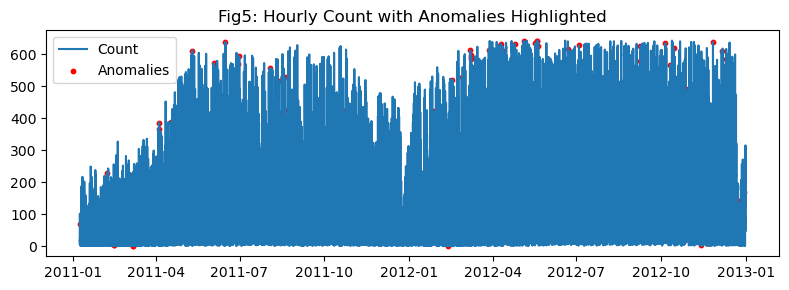

In [420]:
iso = IsolationForest(contamination=0.01, random_state=42)
Xf = StandardScaler().fit_transform(df[['temp','hum','windspeed','cnt']])
df['anomaly'] = iso.fit_predict(Xf)
print("Anomalies flagged by IsolationForest:", (df['anomaly']==-1).sum())

plt.figure(figsize=(8,3))
plt.plot(df.index, df['cnt'], label='Count')
plt.scatter(df.index[df['anomaly']==-1], df['cnt'][df['anomaly']==-1],
            c='r', s=10, label='Anomalies')
plt.legend(); plt.title("Fig5: Hourly Count with Anomalies Highlighted")
plt.tight_layout(); plt.savefig("figs/Anomalies-time.png", dpi=300); plt.show()

# 10. Save the final model

In [422]:
pickle.dump(best_rf, open("rf_model.pkl","wb"))

# 11. Results and Visualizations

In [424]:
summary = pd.DataFrame({
    "Model": ["RF (base)", "RF + KMeans", "RF + GMM"],
    "RMSE Mean": [scores_base.mean(), scores_km.mean(), scores_gmm.mean()],
    "RMSE Std":  [scores_base.std(),  scores_km.std(),  scores_gmm.std()]
})
print(summary)

         Model  RMSE Mean  RMSE Std
0    RF (base)  54.217123  8.471395
1  RF + KMeans  51.690954  8.094159
2     RF + GMM  51.671741  9.096964


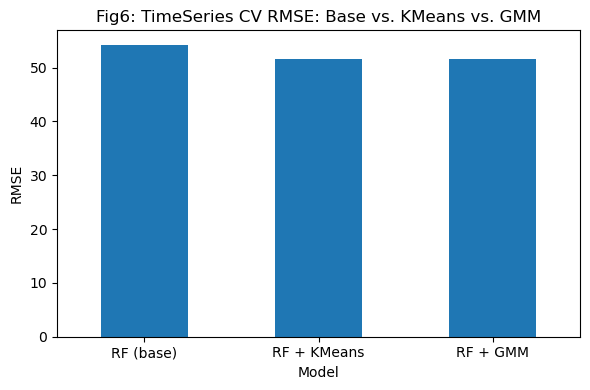

In [426]:
ax = summary.set_index("Model")["RMSE Mean"].plot.bar(
    yerr=summary["RMSE Std"], rot=0, figsize=(6,4)
)
ax.set_ylabel("RMSE")
ax.set_title("Fig6: TimeSeries CV RMSE: Base vs. KMeans vs. GMM")
plt.tight_layout()
plt.savefig("figs/TimeSeries-CV-RMSE-Base-vs-KMeans-vs-GMM.png", dpi=300)
plt.show()

In [428]:
# A. Supervised summary
sup_summary = pd.DataFrame({
    "Model":    ["RF (base)", "RF + KMeans", "RF + GMM"],
    "RMSE_Mean":[scores_base.mean(), scores_km.mean(), scores_gmm.mean()],
    "RMSE_Std": [scores_base.std(),  scores_km.std(),  scores_gmm.std()]
})
sup_summary["Paradigm"] = "Supervised"

# B. Semi-supervised summary: average across fractions for each algorithm
semi_summary = pd.DataFrame({
    "Model": ["Label Propagation", "Logistic Regression"],
    "Accuracy_Mean": [ res_df["LP_acc"].mean(), res_df["LR_acc"].mean() ],
    "F1_Mean":       [ res_df["LP_f1"].mean(),  res_df["LR_f1"].mean()  ],
    "ROC_AUC_Mean":  [ res_df["LP_roc"].mean(), res_df["LR_roc"].mean() ]
})
semi_summary["Paradigm"] = "Semi-supervised"

# C. Combine into one DataFrame
agg = pd.concat([
    sup_summary.rename(columns={
        "RMSE_Mean":"Metric1_Mean","RMSE_Std":"Metric1_Std"
    }),
    semi_summary.rename(columns={
        "Accuracy_Mean":"Metric1_Mean",
        "F1_Mean":      "Metric2_Mean",
        "ROC_AUC_Mean": "Metric3_Mean"
    })
], sort=False).reset_index(drop=True)

# Display
print(agg)

                 Model  Metric1_Mean  Metric1_Std         Paradigm  \
0            RF (base)     54.217123     8.471395       Supervised   
1          RF + KMeans     51.690954     8.094159       Supervised   
2             RF + GMM     51.671741     9.096964       Supervised   
3    Label Propagation      0.877858          NaN  Semi-supervised   
4  Logistic Regression      0.912328          NaN  Semi-supervised   

   Metric2_Mean  Metric3_Mean  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN  
3      0.877854      0.949889  
4      0.912320      0.971368  


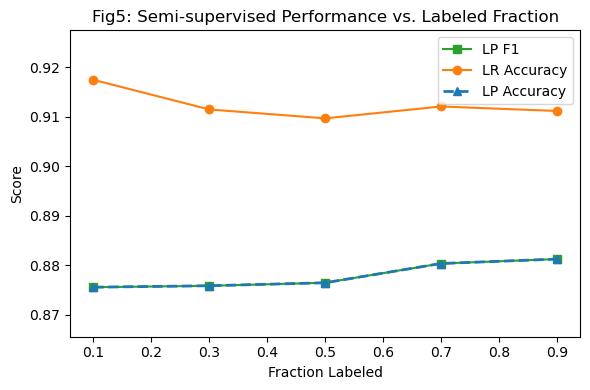

In [434]:
fig, ax = plt.subplots(figsize=(6,4))

# 1. LP F1 (green), drawn first
ax.plot(
    res_df['frac'], res_df['LP_f1'],
    marker='s', linestyle='-', label='LP F1', color='C2'
)

# 2. LR Accuracy (orange)
ax.plot(
    res_df['frac'], res_df['LR_acc'],
    marker='o', linestyle='-', label='LR Accuracy', color='C1'
)

# 3. LP Accuracy (blue dashed), drawn last so it’s on top
ax.plot(
    res_df['frac'], res_df['LP_acc'],
    marker='^', linestyle='--', label='LP Accuracy', color='C0', linewidth=2, zorder=5
)

ymin = res_df[['LP_acc','LR_acc','LP_f1']].min().min() - 0.01
ymax = res_df[['LP_acc','LR_acc','LP_f1']].max().max() + 0.01
ax.set_ylim(ymin, ymax)

# Labels and legend
ax.set_xlabel('Fraction Labeled')
ax.set_ylabel('Score')
ax.set_title('Fig5: Semi-supervised Performance vs. Labeled Fraction')
ax.legend()

plt.tight_layout()
plt.savefig("figs/Semi-supervised-Performance-vs-Labeled-Fraction.png", dpi=300)
plt.show()


In [432]:
print(f"Data after outlier drop: {len(df)} records")

Data after outlier drop: 16706 records
